# Задание
Выберите ряд и постройте его модель ARIMA/GARCH.
Не обязательное дз. Попробуйте спрогнозировать график классическим ML

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt

from statsmodels.tsa.stattools import adfuller

from scipy.stats import boxcox

import matplotlib.pyplot as plt
%matplotlib inline

from arch import arch_model

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
        
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
        
    return

In [4]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [5]:
#Исходный TS
series = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")['Count']

### Применим ARIMA. 
Предобрабатывать ряд я специально не стал - хотел посмотреть, что будет.

In [6]:
aic, order, mdl = _get_best_model(series)

aic: 858.17298 | order: (3, 1, 2)


Results of Dickey-Fuller Test:
Test Statistic                 -2.024892
p-value                         0.275767
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


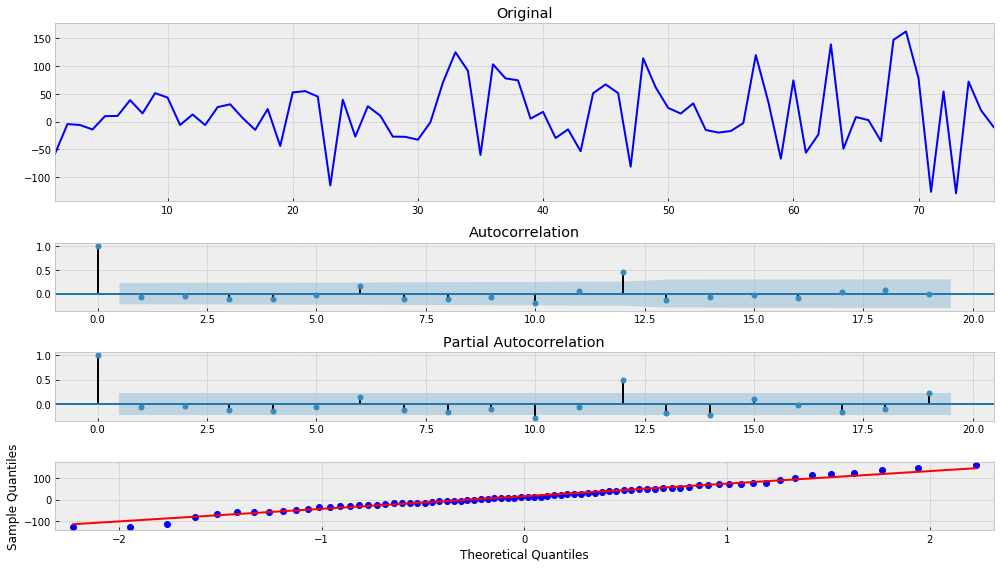

In [7]:
tsplot(mdl.resid)

p-value велико, да и по остаткам видно, что модель не очень.

### Применим GARCH

In [8]:
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')

print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                        Count   R-squared:                      -0.126
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.126
Vol Model:                        GJR-GARCH   Log-Likelihood:               -498.294
Distribution:      Standardized Student's t   AIC:                           1014.59
Method:                  Maximum Likelihood   BIC:                           1035.68
                                              No. Observations:                   77
Date:                      Tue, Mar 03 2020   Df Residuals:                       68
Time:                              23:36:22   Df Model:                            9
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

D:\Program_Files\Anaconda\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.886e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


D:\Program_Files\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


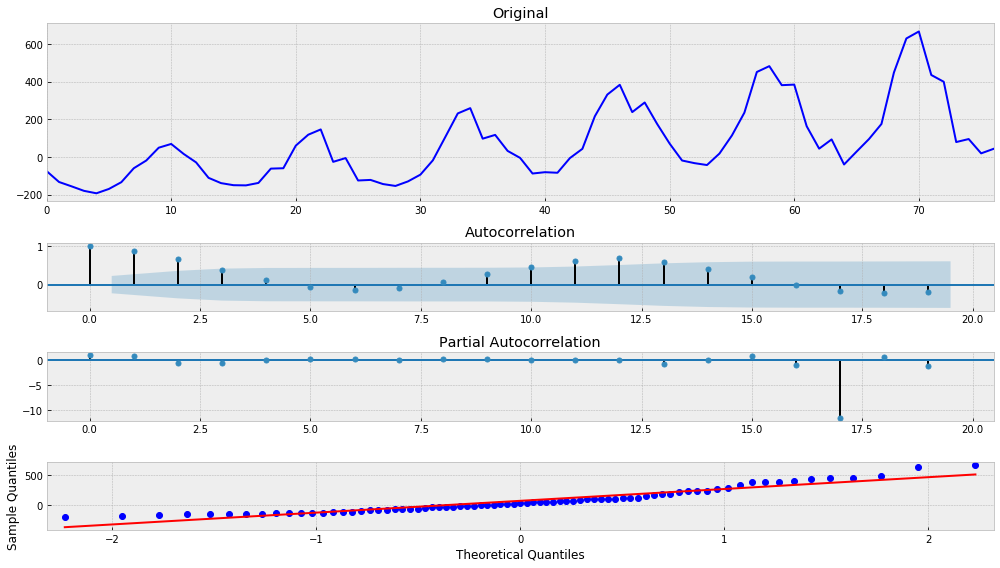

In [9]:
tsplot(res.resid)

p-value стало ещё больше, остатки разбежались ещё сильнее, по сравнению с моделью ARCH.

### Теперь с boxcox

Results of Dickey-Fuller Test:
Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


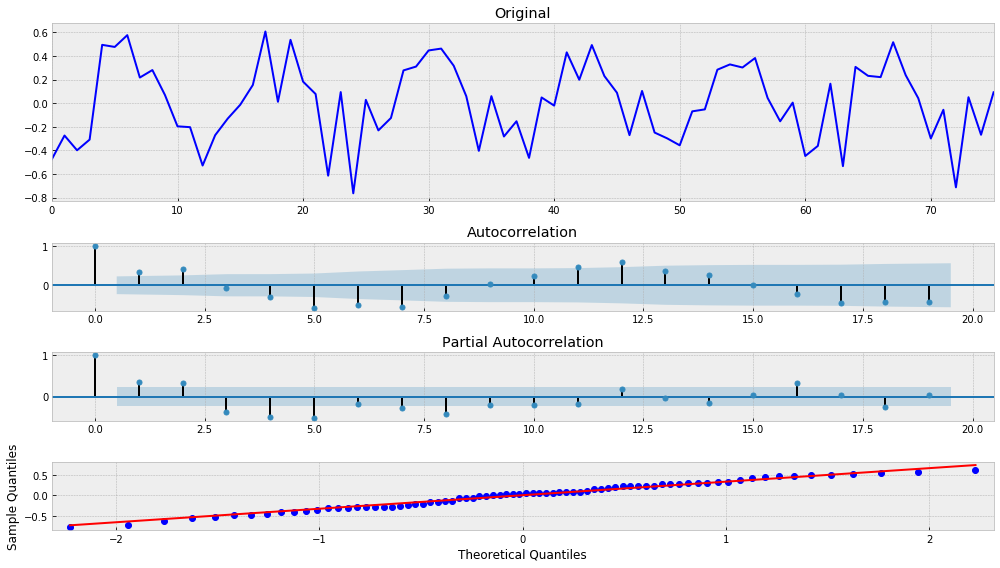

In [10]:
new_series = boxcox(series, 0)
new_series = new_series[1:] - new_series[:-1]
tsplot(new_series)

p-value меньше .05, PA - быстро затухает, остатки на концах собрались к прямой.

#### Применим ARIMA. 

D:\Program_Files\Anaconda\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


aic: -33.21456 | order: (3, 0, 2)
Results of Dickey-Fuller Test:
Test Statistic                -9.171942e+00
p-value                        2.375352e-15
#Lags Used                     0.000000e+00
Number of Observations Used    7.500000e+01
Critical Value (1%)           -3.520713e+00
Critical Value (5%)           -2.900925e+00
Critical Value (10%)          -2.587781e+00
dtype: float64


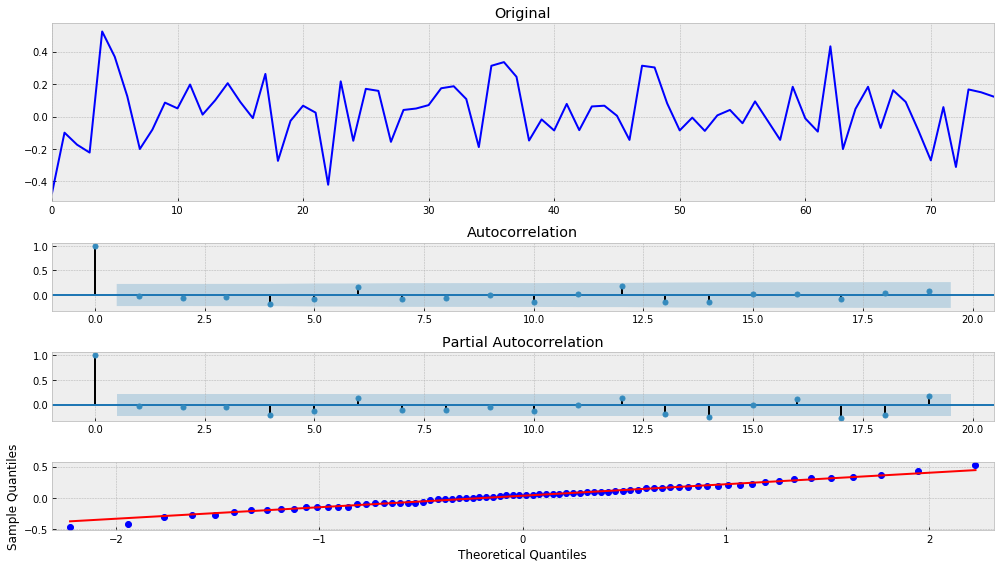

In [11]:
aic, order, mdl = _get_best_model(new_series)
tsplot(mdl.resid)

#### Применим GARCH

In [12]:
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(new_series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')

print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.001
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                            GARCH   Log-Likelihood:               -21.9291
Distribution:      Standardized Student's t   AIC:                           59.8582
Method:                  Maximum Likelihood   BIC:                           78.5041
                                              No. Observations:                   76
Date:                      Tue, Mar 03 2020   Df Residuals:                       68
Time:                              23:36:30   Df Model:                            8
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

Results of Dickey-Fuller Test:
Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


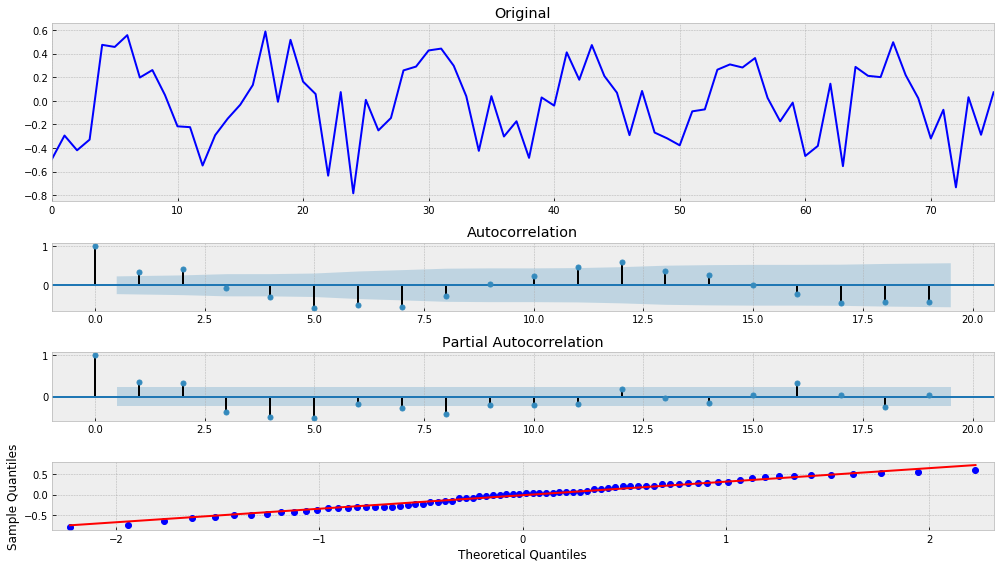

In [13]:
tsplot(res.resid)

### ARIMA оказался лучше, чем GARCH на этом временном ряде.